# Model Consolidation

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt   
%matplotlib inline
from music21 import *
from IPython.display import Audio
from intervaltree import Interval,IntervalTree
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore')




In [2]:
# Clears file to re-generate every time this notebook is run
# If this is not run each model result will be appended onto the existing file
! rm -r ../output/dev_results


### Import csv features which were extracted from earlier Data PreProcessing notebook

In [3]:
X_train_w = pd.read_csv('../data/X_train_w.csv',index_col = 0)
X_train_m = pd.read_csv('../data/X_train_m.csv',index_col = 0)
X_train_c = pd.read_csv('../data/X_train_c.csv',index_col = 0)
X_test_w = pd.read_csv('../data/X_test_w.csv',index_col = 0)
X_test_m = pd.read_csv('../data/X_test_m.csv',index_col = 0)
X_test_c = pd.read_csv('../data/X_test_c.csv',index_col = 0)
y_train_w = pd.read_csv('../data/y_train_w.csv',index_col = 0)
y_train_m = pd.read_csv('../data/y_train_m.csv',index_col = 0)
y_train_c = pd.read_csv('../data/y_train_c.csv',index_col = 0)
y_test_w = pd.read_csv('../data/y_test_w.csv',index_col = 0)
y_test_m = pd.read_csv('../data/y_test_m.csv',index_col = 0)
y_test_c = pd.read_csv('../data/y_test_c.csv',index_col = 0)

In [4]:
print('Shape of Wav Data :')
print( X_train_w.shape, y_train_w.shape , X_test_w.shape , y_test_w.shape)
print('Shape of MIDI Data :')
print( X_train_m.shape, y_train_m.shape , X_test_m.shape , y_test_m.shape)
print('Shape of Combined Wav and MIDI Data :')
print( X_train_c.shape, y_train_c.shape , X_test_c.shape , y_test_c.shape)

Shape of Wav Data :
(263, 167) (263, 1) (66, 167) (66, 1)
Shape of MIDI Data :
(263, 10) (263, 1) (66, 10) (66, 1)
Shape of Combined Wav and MIDI Data :
(263, 176) (263, 1) (66, 176) (66, 1)


# Models

## 1. Logistic Regression

### 1.1 Spectral (WAV) Data Only

#### 1.1.1 Baseline model

In [5]:
#Create Baseline Logistic Model
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_w), np.array(y_train_w))
#cross validation with 5 fold on training data
scores = cross_val_score(estimator = lr, X=X_train_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1, scoring='f1_weighted')
# output (printed to text file and displayed within notebook)
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 1.1.1\n'
model_type = 'Logistic Regression Baseline Model (wav data only)\n'
model_scores = f'CV Scores: {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 1.1.1
 Logistic Regression Baseline Model (wav data only)
 CV Scores: [0.86865022 0.88865687 0.86914011 0.86424772 0.93960864]
 CV Average and standard deviation: 0.8860607118376898 +/- 0.028069053819395614



#### 1.1.2 PCA components

Explained Variance with 1 Principal Components: 84.97%
Explained Variance with 2 Principal Components: 94.32%
Explained Variance with 3 Principal Components: 96.57%
Explained Variance with 4 Principal Components: 97.40%
Explained Variance with 5 Principal Components: 98.08%
Explained Variance with 6 Principal Components: 98.42%
Explained Variance with 7 Principal Components: 98.69%
Explained Variance with 8 Principal Components: 98.95%
Explained Variance with 9 Principal Components: 99.14%
Explained Variance with 10 Principal Components: 99.27%
Explained Variance with 11 Principal Components: 99.36%
Explained Variance with 12 Principal Components: 99.43%
Explained Variance with 13 Principal Components: 99.49%
Explained Variance with 14 Principal Components: 99.55%
Explained Variance with 15 Principal Components: 99.60%
Explained Variance with 16 Principal Components: 99.64%
Explained Variance with 17 Principal Components: 99.68%
Explained Variance with 18 Principal Components: 99.71%
E

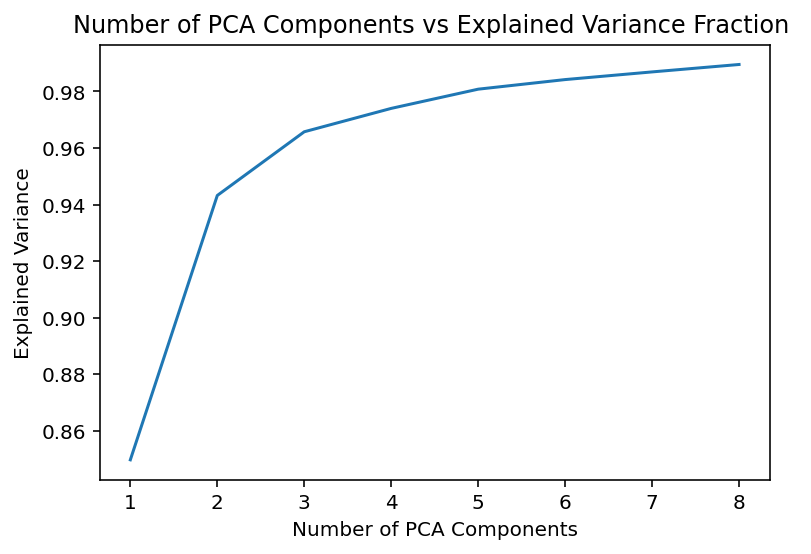

Model #: 1.1.2
 Logistic Regression with PCA (wav data only)
 CV Scores [0.56137119 0.63606575 0.56957999 0.6098125  0.58377868]
 CV Average and standard deviation: 0.592121620802015 +/- 0.027449490564249102



In [6]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_w.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
for x,y in zip(all_possible_k,all_possible_k_variance):
    print("Explained Variance with {} Principal Components: {:.2%}".format(x,y))

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
# save plot to output/plots folder
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.savefig('../output/plots/1.1.2_PCA_Components.png')
plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_w)
X_train_pca = pca.transform(X_train_w)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_w)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w.values.ravel(), cv=5, n_jobs=1,  scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 1.1.2\n'
model_type = 'Logistic Regression with PCA (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

### 1.2 MIDI Data Only 

#### 1.2.1 Baseline model

In [7]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_m), np.array(y_train_m))
scores = cross_val_score(estimator = lr, X=X_train_m, y=y_train_m, cv=5, n_jobs=1,  scoring='f1_weighted')
# save and print output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 1.2.1\n'
model_type = 'Logistic Regression Baseline Model (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 1.2.1
 Logistic Regression Baseline Model (midi data only)
 CV Scores [0.60700212 0.69156365 0.64708525 0.61101106 0.69564979]
 CV Average and standard deviation: 0.6504623758731147 +/- 0.037915226747904124



#### 1.2.2 PCA components

[0.8472469251566341, 0.9999994828649595, 0.9999999950423859, 0.9999999979326265, 0.9999999995373897, 0.9999999998110076, 0.9999999999006716, 0.9999999999631858]


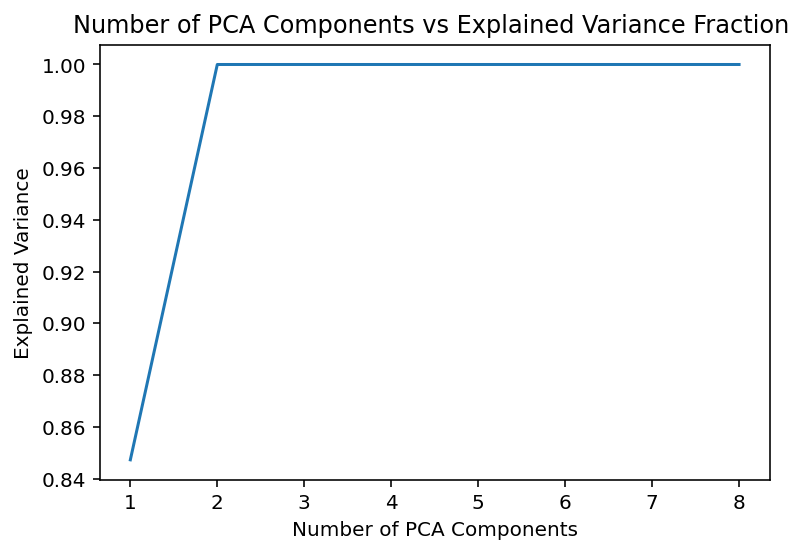

Model #: 1.2.2
 Logistic Regression with PCA (midi data only)
 CV Scores [0.30237059 0.30629748 0.13595105 0.31218781 0.31218781]
 CV Average and standard deviation: 0.27379894625177637 +/- 0.06902455626074773



In [8]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_m.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_m)
    train_pca = pca.transform(X_train_m)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
# save plot
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.savefig('../output/plots/1.2.2 PCA Components.png')
plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_m)
X_train_pca = pca.transform(X_train_m)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_w)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1,  scoring='f1_weighted')
# save and print output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 1.2.2\n'
model_type = 'Logistic Regression with PCA (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

### 1.3 Combined Data (WAV & MIDI) 

#### 1.3.1 Baseline model

In [9]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_c), np.array(y_train_c))
scores = cross_val_score(estimator = lr, X=X_train_c, y=y_train_c, cv=5, n_jobs=1,  scoring='f1_weighted')
# save and print output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 1.3.1\n'
model_type = 'Logistic Regression Baseline Model (combined midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 1.3.1
 Logistic Regression Baseline Model (combined midi and wav data)
 CV Scores [0.75553733 0.80632889 0.87739767 0.76783724 0.91410795]
 CV Average and standard deviation: 0.8242418150180602 +/- 0.06184516768275534



#### 1.3.2 PCA components

[0.8472467564714535, 0.9999993006005323, 0.9999998191050802, 0.9999999250480672, 0.9999999510448121, 0.9999999628415001, 0.9999999703478009, 0.9999999753281146]


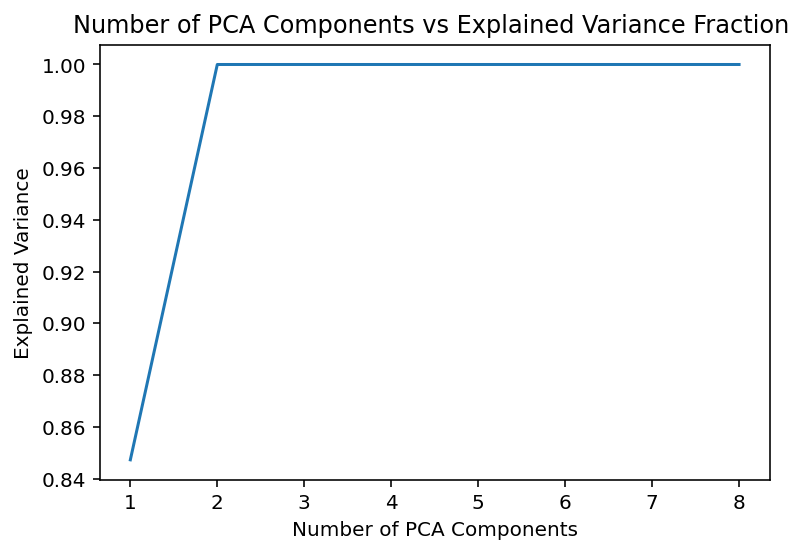

Model #: 1.3.2
 Logistic Regression with PCA (combined midi and wav data)
 CV Scores [0.30237059 0.28550149 0.28550149 0.31218781 0.30769231]
 CV Average and standard deviation: 0.2986507368831103 +/- 0.011177165052539052



In [10]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_c.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_c)
    train_pca = pca.transform(X_train_c)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
# save plot
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.savefig('../output/plots/1.3.2 PCA Components.png')
plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_c)
X_train_pca = pca.transform(X_train_c)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_c)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1,  scoring='f1_weighted')
# save and print output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 1.3.2\n'
model_type = 'Logistic Regression with PCA (combined midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

## 2. Naive Bayes

### 2.1 Spectral (WAV) Data Only

#### 2.1.1 Baseline model

In [11]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_w, y=y_train_w, cv=5, n_jobs=1, scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 2.1.1\n'
model_type = 'Naive Bayes Baseline Model (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 2.1.1
 Naive Bayes Baseline Model (wav data only)
 CV Scores [0.66838433 0.70943396 0.68252735 0.65248458 0.62065018]
 CV Average and standard deviation: 0.666696081533981 +/- 0.029672200294891975



### 2.2 MIDI Data Only

#### 2.2.1 Baseline model

In [12]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_m, y=y_train_m, cv=5, n_jobs=1, scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 2.2.1\n'
model_type = 'Naive Bayes Baseline Model (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 2.2.1
 Naive Bayes Baseline Model (midi data only)
 CV Scores [0.58334988 0.34132445 0.69291669 0.56844181 0.75836225]
 CV Average and standard deviation: 0.588879019523674 +/- 0.1423235166205818



### 2.3 Combined Data (WAV & MIDI)

#### 2.3.1 Baseline model

In [13]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_c, y=y_train_c, cv=5, n_jobs=1, scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 2.3.1\n'
model_type = 'Naive Bayes Baseline Model (combined midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 2.3.1
 Naive Bayes Baseline Model (combined midi and wav data)
 CV Scores [0.73519671 0.76483122 0.76776437 0.73039216 0.71722722]
 CV Average and standard deviation: 0.7430823327079817 +/- 0.01986920881385733



## 3. Decision Tree

### 3.1 Spectral (WAV) Data Only

#### 3.1.1 Baseline model

In [14]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_w, y=y_train_w, cv=5, n_jobs=1, scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 3.1.1\n'
model_type = 'Decision Tree Baseline Model (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 3.1.1
 Decision Tree Baseline Model (wav data only)
 CV Scores [0.72745952 0.77567092 0.79481132 0.77145551 0.66595442]
 CV Average and standard deviation: 0.7470703369096457 +/- 0.04616537327436552



### 3.2 MIDI Data Only

#### 3.2.1 Baseline model

In [15]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_m, y=y_train_m, cv=5, n_jobs=1, scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 3.2.1\n'
model_type = 'Decision Tree Baseline Model (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 3.2.1
 Decision Tree Baseline Model (midi data only)
 CV Scores [0.81895777 0.78785778 0.81469712 0.92220937 0.85865682]
 CV Average and standard deviation: 0.8404757738402061 +/- 0.04670577568106723



### 3.3 Combined Data (WAV & MIDI)

#### 3.3.1 Baseline model

In [16]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_c, y=y_train_c, cv=5, n_jobs=1, scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 3.3.1\n'
model_type = 'Decision Tree Baseline Model (combined midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 3.3.1
 Decision Tree Baseline Model (combined midi and wav data)
 CV Scores [0.80880503 0.82527653 0.80332963 0.90938886 0.88919414]
 CV Average and standard deviation: 0.8471988373685736 +/- 0.0436128031564995



## 4. Random Forest

### 4.1 Spectral (WAV) Data Only

#### 4.1.1 Baseline model

Model #: 4.1.1
 Random Forest Baseline Model (wav data only)
 CV Scores [0.78730369 0.75520077 0.68104223 0.81206294 0.78966219]
 CV Average and standard deviation: 0.7650543635995474 +/- 0.045750444111543



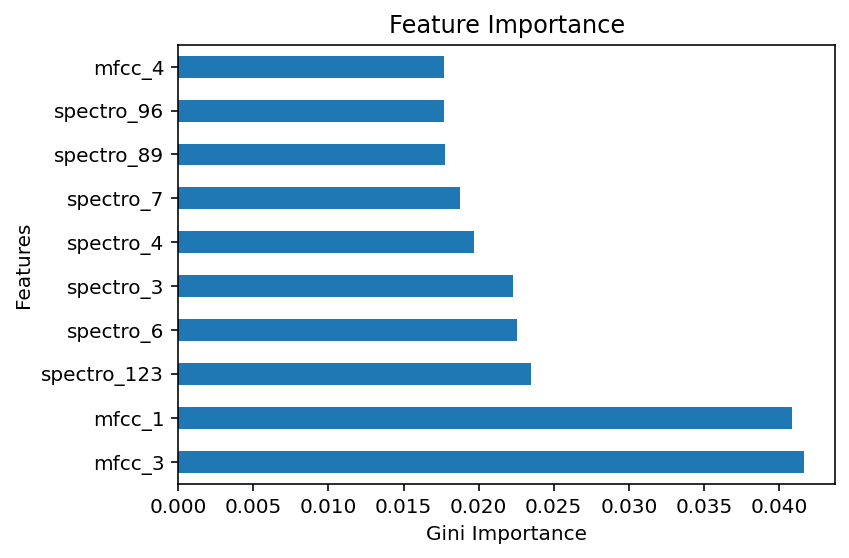

In [17]:
rf = RandomForestClassifier()
rf.fit(X_train_w, y_train_w)
scores = cross_val_score(estimator = rf, X=X_train_w, y=y_train_w, cv=5, n_jobs=1, scoring='f1_weighted')
# save and print output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 4.1.1\n'
model_type = 'Random Forest Baseline Model (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

# plots feature importants and saves plot
feat_importances = pd.Series(rf.feature_importances_, index=X_train_w.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Gini Importance')
plt.tight_layout()
plt.savefig('../output/plots/4.1.1 Feature Importance.png')

#### 4.1.2 Sampling (SMOTE), no hyperparameter tuning

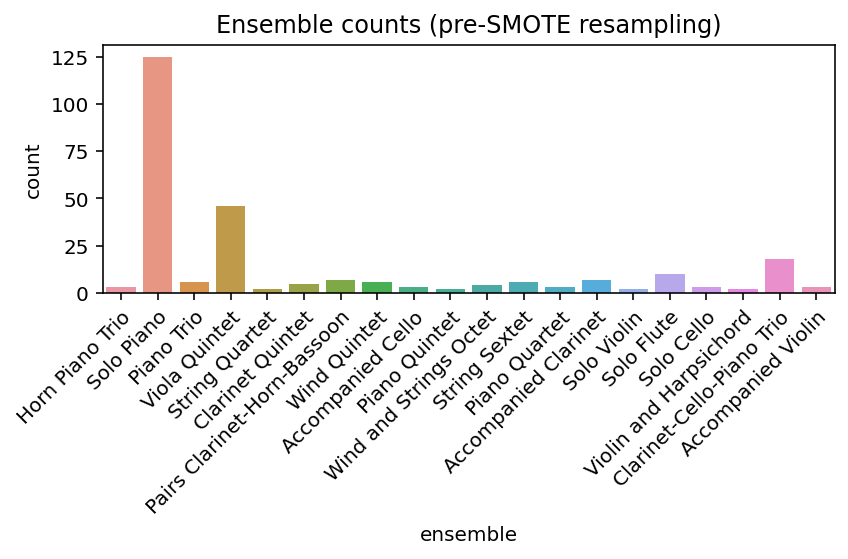

(231, 167) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6})
Resample dataset shape Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})


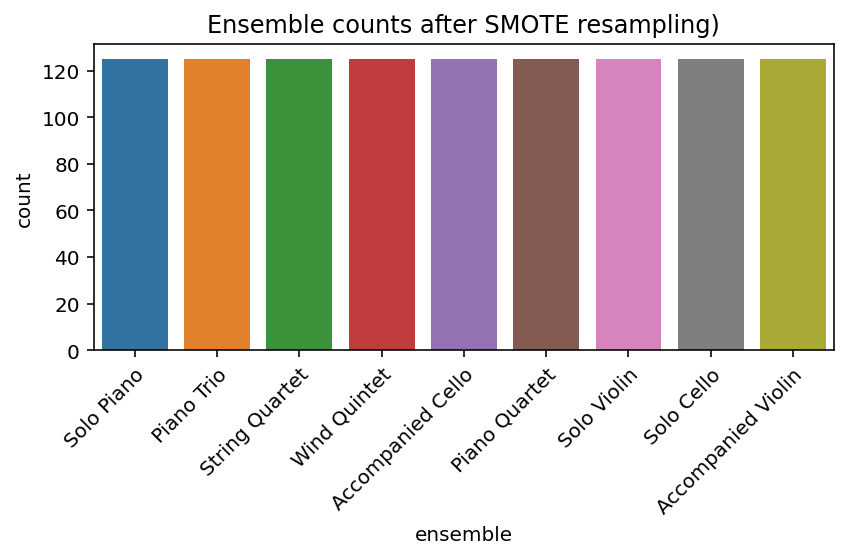

Model #: 4.1.2
 Random Forest with SMOTE and no hyperparameter tuning (wav data only)
 CV Scores [0.99555378 0.98661849 0.99555378 1.         1.        ]
 CV Average and standard deviation: 0.9955452094750207 +/- 0.004886240410560162



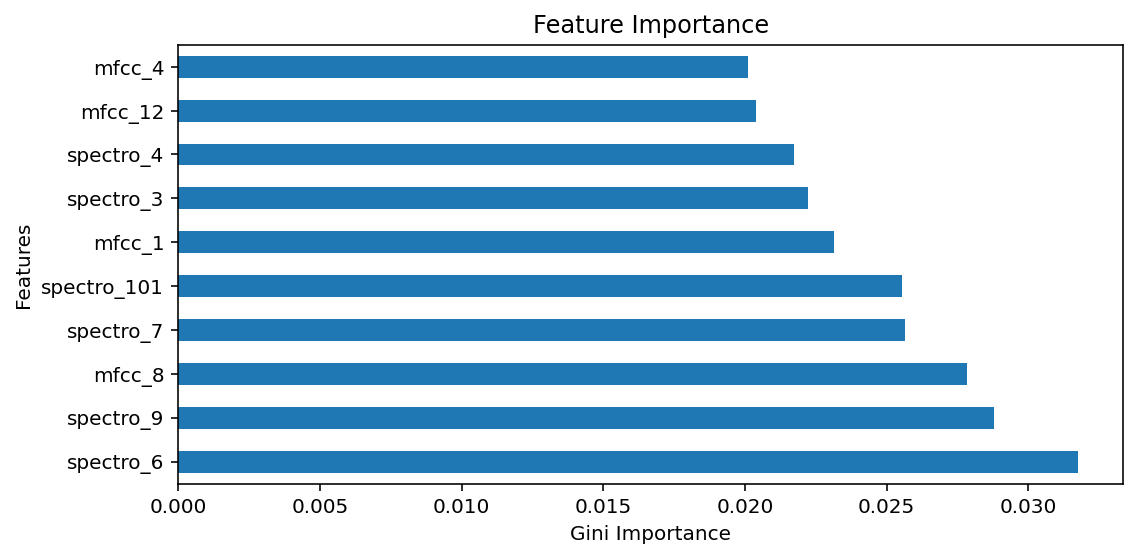

In [18]:
# todo: I think we need to re-import the data for this cell, if this is run multiple times then y_train_w gets overwritten
y_train_w = pd.read_csv('../data/y_train_w.csv',index_col = 0)
# Visualize the target variable
g = sns.countplot(y_train_w['ensemble'])
g.set_xticklabels(['Horn Piano Trio',
'Solo Piano',
'Piano Trio',
'Viola Quintet',
'String Quartet',
'Clarinet Quintet',
'Pairs Clarinet-Horn-Bassoon',
'Wind Quintet',
'Accompanied Cello',
'Piano Quintet',
'Wind and Strings Octet',
'String Sextet',
'Piano Quartet',
'Accompanied Clarinet',
'Solo Violin',
'Solo Flute',
'Solo Cello',
'Violin and Harpsichord',
'Clarinet-Cello-Piano Trio',
'Accompanied Violin'],rotation_mode='anchor',rotation=45, ha='right')
plt.title('Ensemble counts (pre-SMOTE resampling)')
plt.tight_layout()
plt.savefig('../output/plots/4.1.2 Pre-SMOTE Sample Counts.png')
plt.show()

#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_w['ensemble'].value_counts()
X_train_w = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
print(X_train_w.shape, y_train_w.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.


# Fit and apply the transform
X_SMOTE_w, y_SMOTE_w = SMOTE(random_state=101).fit_resample(X_train_w, y_train_w)

print('Original dataset shape', Counter(y_train_w.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_w.values.ravel()))

# Visualize the target variable
g = sns.countplot(y_SMOTE_w['ensemble'])
g.set_xticklabels([
'Solo Piano', 
'Piano Trio',
'String Quartet',
'Wind Quintet',
'Accompanied Cello',
'Piano Quartet',
'Solo Violin',
'Solo Cello',
'Accompanied Violin'],rotation_mode='anchor',rotation=45, ha='right')
plt.title('Ensemble counts after SMOTE resampling)')
plt.tight_layout()
plt.savefig('../output/plots/4.1.2 Post-SMOTE Sample Counts.png')
plt.show()

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_w, y_SMOTE_w)
scores = cross_val_score(estimator = rf, X=X_SMOTE_w, y=y_SMOTE_w, cv=5, n_jobs=1, scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 4.1.2\n'
model_type = 'Random Forest with SMOTE and no hyperparameter tuning (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2
fig, ax = plt.subplots(figsize=(8,4))
feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_w.columns)
ax = feat_importances.nlargest(10).plot(kind='barh')
ax.set_xlabel('Gini Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')
plt.tight_layout()
plt.savefig('../output/plots/4.1.2 Feature Importance.png')
plt.show()

### 4.2 MIDI Data Only

#### 4.2.1 Baseline model

Model #: 4.2.1
 Random Forest Baseline midel (midi data only)
 CV Scores [0.84209344 0.81496193 0.89420722 0.91858974 0.86337701]
 CV Average and standard deviation: 0.8666458683271759 +/- 0.03672201072645839



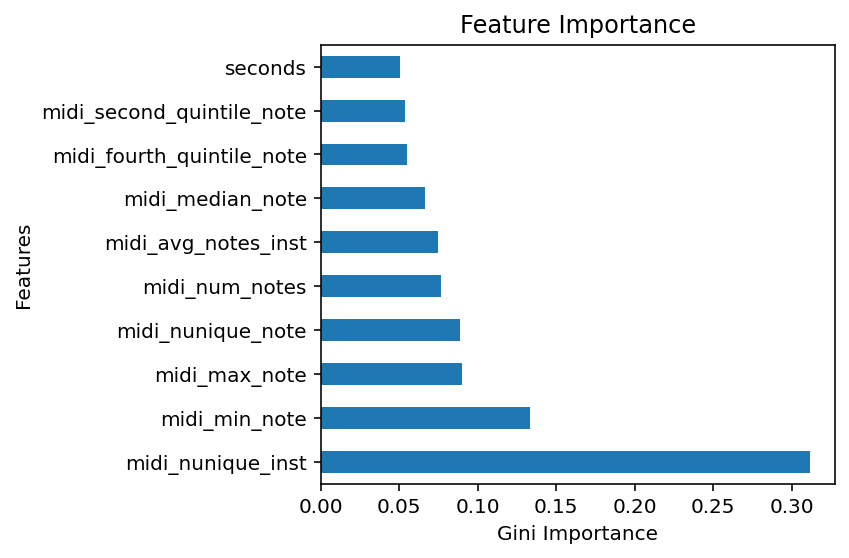

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train_m, y_train_m)
scores = cross_val_score(estimator = rf, X=X_train_m, y=y_train_m, cv=5, n_jobs=1, scoring='f1_weighted')
# print and save output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 4.2.1\n'
model_type = 'Random Forest Baseline midel (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

feat_importances = pd.Series(rf.feature_importances_, index=X_train_m.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('../output/plots/4.2.1 Feature Importance.png')

#### Observation : "midi_nunique instruments" seems to be the variable with the strongest explanatory power with 40% variance explained. We have concerns about evaluating performance using a feature set that includes this variable because in practice we typically would not have manually labelled data. 

#### 4.2.2 Sampling (SMOTE), no hyperparameter tuning

(231, 10) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 7: 7, 14: 7, 2: 6, 8: 6, 12: 6})
Resample dataset shape Counter({1: 125, 2: 125, 4: 125, 7: 125, 8: 125, 12: 125, 14: 125, 16: 125, 19: 125})
Model #: 4.2.2
 Random Forest with SMOTE and no hyperparameter tuning (midi data only)
 CV Scores [0.99555378 0.99555378 0.99555378 0.99555378 0.98661849]
 CV Average and standard deviation: 0.9937667203015735 +/- 0.0035741135296171846



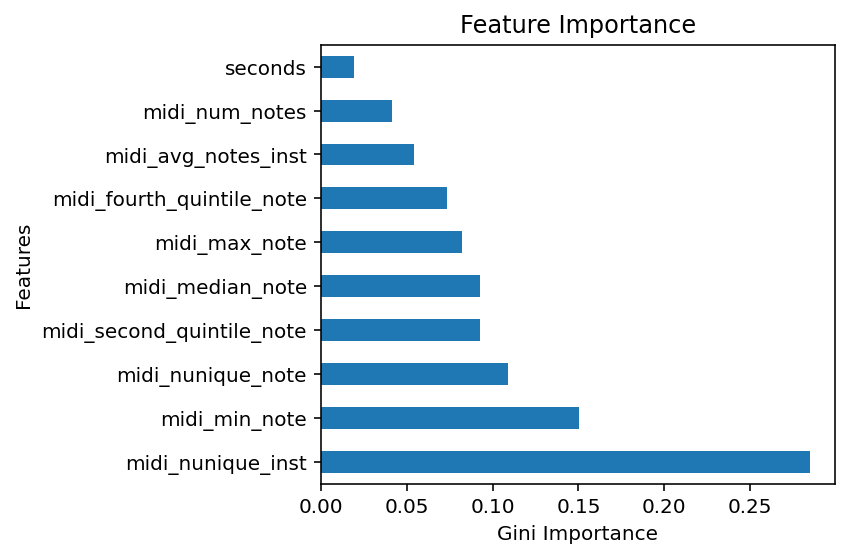

In [20]:
#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_m['ensemble'].value_counts()
X_train_m = X_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
y_train_m = y_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
print(X_train_m.shape, y_train_m.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.

# Fit and apply the transform
X_SMOTE_m, y_SMOTE_m = SMOTE(random_state=101).fit_resample(X_train_m, y_train_m)

print('Original dataset shape', Counter(y_train_m.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_m.values.ravel()))

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_m, y_SMOTE_m)
scores = cross_val_score(estimator = rf, X=X_SMOTE_m, y=y_SMOTE_m, cv=5, n_jobs=1, scoring='f1_weighted')
# Save and print output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 4.2.2\n'
model_type = 'Random Forest with SMOTE and no hyperparameter tuning (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2

# save and print plot 
feat_importances = pd.Series(rf.feature_importances_, index=X_train_m.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Gini Importance')
plt.tight_layout()
plt.savefig('../output/plots/4.2.2 Feature Importance.png')

### 4.3 Combined Data (WAV & MIDI)

#### 4.3.1 Baseline model

Model #: 4.3.1
 Random Forest Baseline Model (midi and wav data)
 CV Scores [0.70286272 0.79078839 0.83299961 0.82696342 0.855052  ]
 CV Average and standard deviation: 0.8017332284031362 +/- 0.053576502220151895



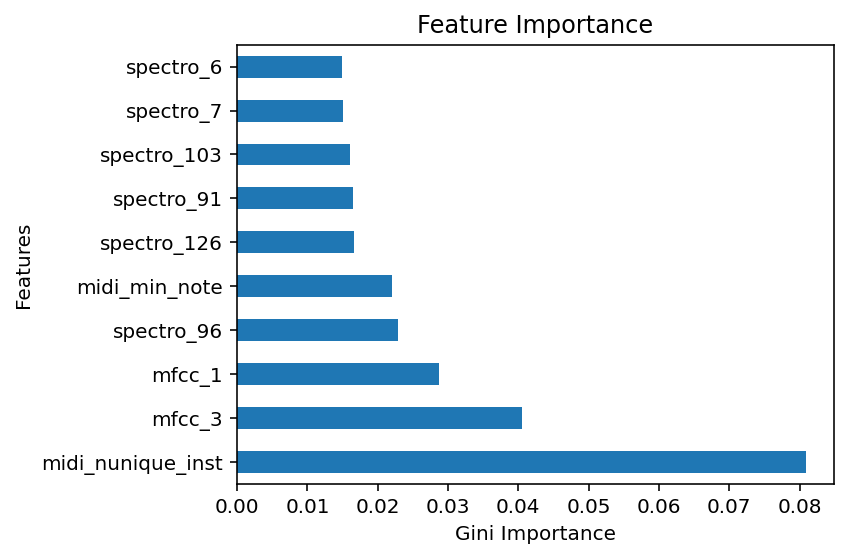

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train_c, y_train_c)
scores = cross_val_score(estimator = rf, X=X_train_c, y=y_train_c, cv=5, n_jobs=1, scoring='f1_weighted')
# prints and saves output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 4.3.1\n'
model_type = 'Random Forest Baseline Model (midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
# print and save plot
feat_importances = pd.Series(rf.feature_importances_, index=X_train_c.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('../output/plots/4.3.1 Feature Importance.png')


####  Observation : We can see here that the midi_nunique_instruments variable is still explaining far more variance in our dataset than any spectral feature. This indicates its strong predictive power in comparison.We have concerns about evaluating performance using a feature set that includes this variable because in practice we typically would not have manually labelled data. 

#### 4.3.2 Sampling (SMOTE), no hyperparameter tuning

(231, 176) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 7: 7, 14: 7, 2: 6, 8: 6, 12: 6})
Resample dataset shape Counter({1: 125, 2: 125, 4: 125, 7: 125, 8: 125, 12: 125, 16: 125, 14: 125, 19: 125})
Model #: 4.3.2
 Random Forest with SMOTE (midi and wave data)
 CV Scores [0.98681349 1.         0.98661849 0.99109687 1.        ]
 CV Average and standard deviation: 0.9929057695674659 +/- 0.006009560297427548



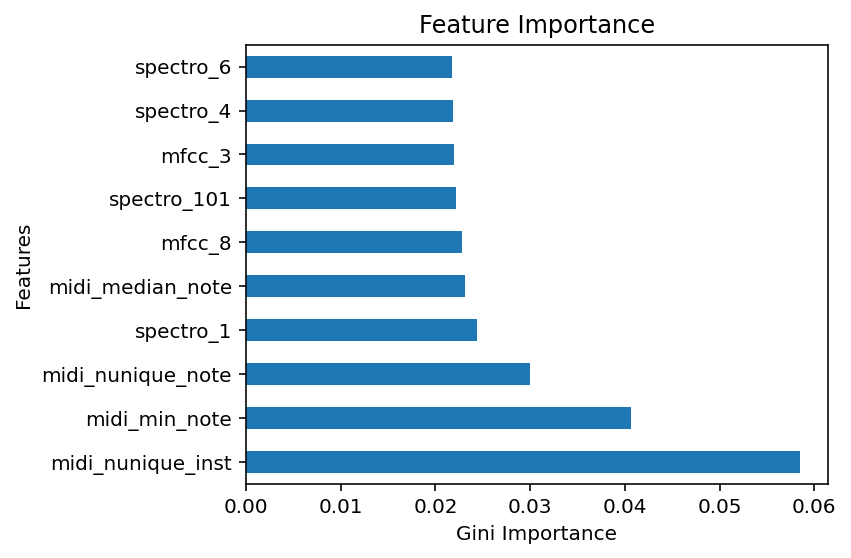

In [22]:
#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_c['ensemble'].value_counts()
X_train_c = X_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
y_train_c = y_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
print(X_train_c.shape, y_train_c.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.

X_SMOTE_c, y_SMOTE_c = SMOTE(random_state=101).fit_resample(X_train_c, y_train_c)

print('Original dataset shape', Counter(y_train_c.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_c.values.ravel()))


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_c, y_SMOTE_c)
scores = cross_val_score(estimator = rf, X=X_SMOTE_c, y=y_SMOTE_c, cv=5, n_jobs=1, scoring='f1_weighted')
# prints and saves output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 4.3.2\n'
model_type = 'Random Forest with SMOTE (midi and wave data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)
#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2
    
feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_c.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('../output/plots/4.3.2 Feature Importance.png')

#### Observation : 

- Midi_min_note variable also has strong predictive power. Certain ensembles will have instruments that allow for lower notes to be played so the lowest note would probably be a good predictor of the ensemble. 

- Midi_nunique_note is important because ensembles composed of instruments with larger ranges will typically have a higher possibility of playing unique notes due to their unique access to notes that other ensembles might not have access to.

## 5. SVM

### 5.1 Spectral (WAV) Data Only

#### 5.1.1 Baseline model

In [23]:
#Create baseline SVM model with Spectral Data

svm = make_pipeline(SVC())
svm.fit(X_train_w, y_train_w.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5,n_jobs=1, scoring='f1_weighted')
# prints and saves output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 5.1.1\n'
model_type = 'SVM Baseline Model (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 5.1.1
 SVM Baseline Model (wav data only)
 CV Scores [0.4500337  0.57625949 0.546875   0.56943937 0.56943937]
 CV Average and standard deviation: 0.5424093850341674 +/- 0.0472446385868813



#### 5.1.2 Hyperparameter tuning

In [24]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),                     
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid, cv=5)
  
# fitting the model for grid search
grid.fit(X_train_w, y_train_w.values.ravel())

print(grid.best_params_)


#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(X_train_w, y_train_w.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1, scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 5.1.2\n'
model_type = 'SVM with hyperparameter tuning (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

{'C': 0.0018329807108324356, 'gamma': 0.001, 'kernel': 'linear'}
Model #: 5.1.2
 SVM with hyperparameter tuning (wav data only)
 CV Scores [0.86308037 0.89613527 0.91137238 0.90434783 0.9458653 ]
 CV Average and standard deviation: 0.9041602276293361 +/- 0.02662073767043021



#### 5.1.3 Hyperparameter tuning, PCA

    Number of PCA Components  Explained Fraction of Total Variance
0                          1                              0.861122
1                          2                              0.952000
2                          3                              0.972518
3                          4                              0.979182
4                          5                              0.985610
5                          6                              0.988322
6                          7                              0.990523
7                          8                              0.992320
8                          9                              0.993631
9                         10                              0.994591
10                        11                              0.995296
11                        12                              0.995868
12                        13                              0.996329
13                        14                              0.99

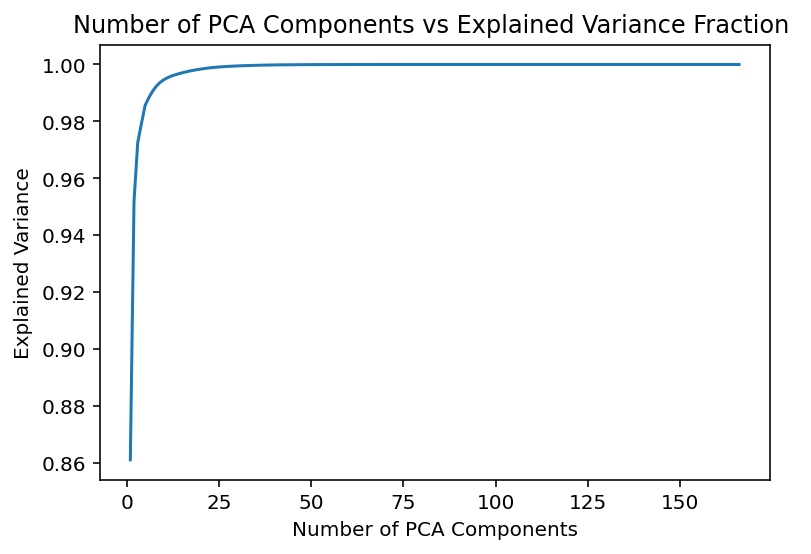

{'C': 0.0018329807108324356, 'gamma': 0.001, 'kernel': 'linear'}
Model #: 5.1.3
 SVM with hyperparameter tuning and PCA (wav data only)
 CV Scores [0.88492926 0.86422578 0.87544813 0.91543052 0.91382869]
 CV Average and standard deviation: 0.8907724766879015 +/- 0.020558763515073564



In [25]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 166 i.e. one less than 167
all_possible_k = np.arange(1,167)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    


plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.savefig('../output/plots/5.1.3 PCA Plot.png')
plt.show()

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_train_w)
train_pca_w = pca.transform(X_train_w)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w, y_train_w.values.ravel())

print(grid.best_params_)

#Create Model with best hyperparameters and PCA
svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w, y_train_w.values.ravel())


#Apply 5 fold cross validation scoring to make sure results are reliable
scores = cross_val_score(estimator = svm, X=train_pca_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1, scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 5.1.3\n'
model_type = 'SVM with hyperparameter tuning and PCA (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)


#### Observation : PCA does not reduce score but reduces number of features to just 15 principal components

 #### 5.1.4 Hyperparameter tuning, PCA, SMOTE

Before oversampling:  Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6})
(231, 167) (231, 1)
After oversampling:  Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})
    Number of PCA Components  Explained Fraction of Total Variance
0                          1                              0.804078
1                          2                              0.924845
2                          3                              0.965160
3                          4                              0.978558
4                          5                              0.984787
5                          6                              0.988936
6                          7                              0.991446
7                          8                              0.992552
8                          9                              0.993644
9                         10                              0.994564
10                        11             

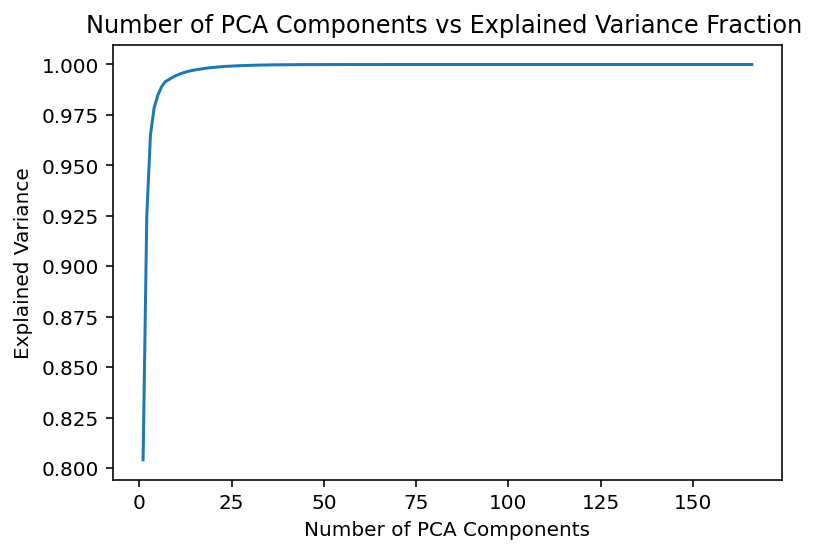

{'C': 0.08858667904100823, 'gamma': 0.001, 'kernel': 'linear'}
Model #: 5.1.4
 SVM with Hyperparameter tuning, PCA, SMOTE (wav data only)
 CV Scores [0.99101307 0.98661849 0.99555378 1.         0.99555378]
 CV Average and standard deviation: 0.9937478238541055 +/- 0.004558922324772249



In [26]:
print("Before oversampling: ",Counter(y_train_w.values.ravel()))

#Drop any ensemble types with counts below 6
counts = y_train_w['ensemble'].value_counts()
X_train_w_smote = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w_smote = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]

#Now print data shape
print(X_train_w_smote.shape, y_train_w_smote.shape)

# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_w_smote, y_train_w_smote.values.ravel())

# summarize class distribution
print("After oversampling: ",Counter(y_SMOTE))

# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_w_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 166 i.e. one less than 167
all_possible_k = np.arange(1,167)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_w_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    

plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.savefig('../output/plots/5.1.4 PCA Plot.png')
plt.show()

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_SMOTE)
train_pca_w_smote = pca.transform(X_SMOTE)


from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w_smote, y_SMOTE)

print(grid.best_params_)

#Create SVM model with best hyperparameters, PCA and SMOTE

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1, scoring='f1_weighted')

#print and save output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 5.1.4\n'
model_type = 'SVM with Hyperparameter tuning, PCA, SMOTE (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

#### 5.1.5 Hyperparameter tuning, PCA, SMOTE, Min Max Scaler

In [27]:
#### MinMaxScaler Application

#Create SVM model with best hyperparameters, PCA and SMOTE and MinMaxScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1, scoring='f1_weighted')

#Apply 5 fold cross validation scoring to make sure results are reliable
# Print and save output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 5.1.5\n'
model_type = 'SVM with Hyperparameter tuning, PCA, SMOTE, and Min Max Scaler (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 5.1.5
 SVM with Hyperparameter tuning, PCA, SMOTE, and Min Max Scaler (wav data only)
 CV Scores [0.79572816 0.83272429 0.78571959 0.85508471 0.7714211 ]
 CV Average and standard deviation: 0.8081355674777224 +/- 0.03102643765176883



#### 5.1.6 Hyperparameter tuning, PCA, SMOTE, Standard Scaler

In [28]:
#### Standard Scaler Application

#Create SVM model with best hyperparameters, PCA and SMOTE and StandardScaler

svm = make_pipeline(StandardScaler() ,SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1, scoring='f1_weighted')

#Apply 5 fold cross validation scoring to make sure results are reliable
# Print and save output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 5.1.6\n'
model_type = 'SVM with Hyperparameter tuning, PCA, SMOTE, and Standard Scaler (wav data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 5.1.6
 SVM with Hyperparameter tuning, PCA, SMOTE, and Standard Scaler (wav data only)
 CV Scores [0.99110933 0.97320458 0.99101307 1.         0.99109687]
 CV Average and standard deviation: 0.9892847696574811 +/- 0.008752011056756109



### 5.2 MIDI Data Only

#### 5.2.1 Baseline model

In [29]:
#Create baseline SVM model with MIDI Data only

svm = make_pipeline(SVC())
svm.fit(X_train_m, y_train_m.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_m, y=y_train_m.values.ravel(), cv=5,n_jobs=1, scoring='f1_weighted')
# Print and save output
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 5.2.1\n'
model_type = 'SVM Baseline Model (midi data only)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 5.2.1
 SVM Baseline Model (midi data only)
 CV Scores [0.61506698 0.64457282 0.63867212 0.64816685 0.65613692]
 CV Average and standard deviation: 0.6405231357536184 +/- 0.013928807581877036



### 5.3 Combined Data (WAV & MIDI)

#### 5.3.1 Baseline model

In [30]:
#Create baseline SVM model with Spectral Wav and MIDI Data

svm = make_pipeline(SVC())
svm.fit(X_train_c, y_train_c.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c.values.ravel(), cv=5,n_jobs=1, scoring='f1_weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model #: 5.3.1\n'
model_type = 'SVM with Baseline Model (midi and wav data)\n'
model_scores = f'CV Scores {scores}\n'
model_avg_std = f'CV Average and standard deviation: {np.mean(scores)} +/- {np.std(scores)}\n'
output_file.writelines([model_no, model_type, model_scores, model_avg_std])
output_file.close()
print(model_no, model_type, model_scores, model_avg_std)

Model #: 5.3.1
 SVM with Baseline Model (midi and wav data)
 CV Scores [0.61506698 0.64457282 0.63867212 0.64816685 0.65613692]
 CV Average and standard deviation: 0.6405231357536184 +/- 0.013928807581877036



## 6. Neural Network

### 6.1 Spectral (WAV) Data Only

#### 6.1.1 Baseline model

Epoch 1/200
8/8 [==============================] - 1s 5ms/step - loss: 5.4271 - accuracy: 0.2857
Epoch 2/200
8/8 [==============================] - 0s 3ms/step - loss: 1.8618 - accuracy: 0.5325
Epoch 3/200
8/8 [==============================] - 0s 3ms/step - loss: 1.4896 - accuracy: 0.5022
Epoch 4/200
8/8 [==============================] - 0s 5ms/step - loss: 1.2480 - accuracy: 0.6450
Epoch 5/200
8/8 [==============================] - 0s 3ms/step - loss: 1.0839 - accuracy: 0.6537
Epoch 6/200
8/8 [==============================] - 0s 3ms/step - loss: 0.9578 - accuracy: 0.7403
Epoch 7/200
8/8 [==============================] - 0s 4ms/step - loss: 0.8389 - accuracy: 0.7706
Epoch 8/200
8/8 [==============================] - 0s 4ms/step - loss: 0.7156 - accuracy: 0.8095
Epoch 9/200
8/8 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.8052
Epoch 10/200
8/8 [==============================] - 0s 3ms/step - loss: 0.5601 - accuracy: 0.8528
Epoch 11/200
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 85/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 86/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 87/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 88/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 89/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 90/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 91/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 92/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 93/200
8/8 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 94/200
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 1.9915e-04 - accuracy: 1.0000
Epoch 165/200
8/8 [==============================] - 0s 2ms/step - loss: 1.9600e-04 - accuracy: 1.0000
Epoch 166/200
8/8 [==============================] - 0s 2ms/step - loss: 1.9101e-04 - accuracy: 1.0000
Epoch 167/200
8/8 [==============================] - 0s 2ms/step - loss: 1.8862e-04 - accuracy: 1.0000
Epoch 168/200
8/8 [==============================] - 0s 2ms/step - loss: 1.8721e-04 - accuracy: 1.0000
Epoch 169/200
8/8 [==============================] - 0s 2ms/step - loss: 1.8550e-04 - accuracy: 1.0000
Epoch 170/200
8/8 [==============================] - 0s 3ms/step - loss: 1.8145e-04 - accuracy: 1.0000
Epoch 171/200
8/8 [==============================] - 0s 2ms/step - loss: 1.7389e-04 - accuracy: 1.0000
Epoch 172/200
8/8 [==============================] - 0s 2ms/step - loss: 1.7006e-04 - accuracy: 1.0000
Epoch 173/200
8/8 [==============================] - 0s 2ms/step - loss: 1.6798e-04 - a

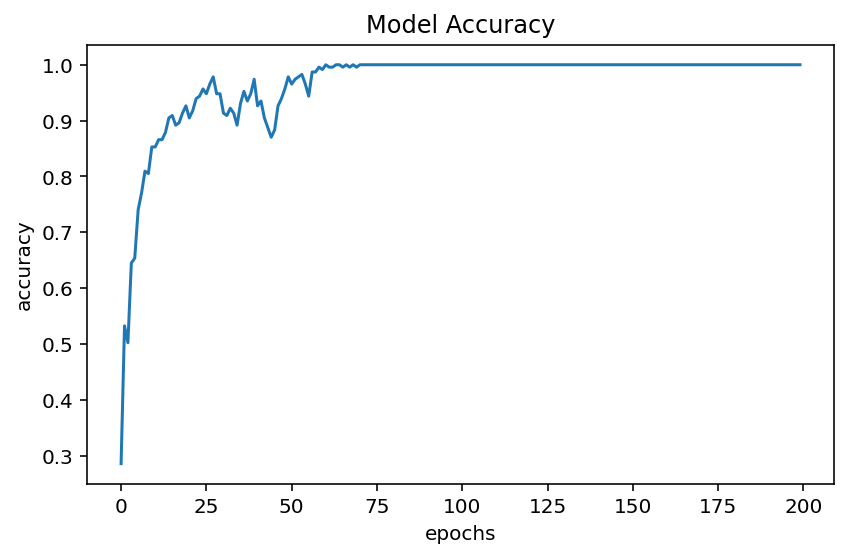

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_w, y_train_w, epochs=200)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.savefig('../output/plots/6.1.1 Accuracy Plot.png')

# predict probabilities for train set
yhat_probs = model.predict(X_train_w, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_train_w, verbose=0)

f1 = f1_score(y_train_w, yhat_classes, average='weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model#: 6.1.1\n'
model_type = 'Neural Network (wav data only)\n'
model_scores = "Test Set F1-score: {:.2%}".format(f1)
output_file.writelines([model_no, model_type, model_scores])
output_file.close()
print(model_no, model_type, model_scores)
pass



#### observation: only using the wave features has the strongest performance in a neral network

### 6.2 MIDI Data Only

#### 6.2.1 Baseline model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_m, y_train_m, epochs=200)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.savefig('../output/plots/6.2.1 Accuracy Plot.png')


# predict probabilities for train set
yhat_probs = model.predict(X_train_m, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_train_m, verbose=0)

f1 = f1_score(y_train_m, yhat_classes, average='weighted')

output_file = open('../output/dev_results', 'a')
model_no = 'Model#: 6.2.1\n'
model_type = 'Neural Network (midi data only)\n'
model_scores = "Test Set F1-score: {:.2%}".format(f1)
output_file.writelines([model_no, model_type, model_scores])
output_file.close()
print(model_no, model_type, model_scores)
pass


### 6.3 Combined Data (WAV & MIDI)

#### 6.3.1 Baseline model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_c, y_train_c, epochs=200)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.savefig('../output/plots/6.3.1 Accuracy Plot.png')

# predict probabilities for train set
yhat_probs = model.predict(X_train_c, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_train_c, verbose=0)

f1 = f1_score(y_train_c, yhat_classes, average='weighted')
output_file = open('../output/dev_results', 'a')
model_no = 'Model#: 6.3.1\n'
model_type = 'Neural Network (midi and wav data)\n'
model_scores = "Test Set F1-score: {:.2%}".format(f1)
output_file.writelines([model_no, model_type, model_scores])
output_file.close()
print(model_no, model_type, model_scores)
pass


### Observation : Cases removed through SMOTE run on the training data will not be classified correctly in the test data step subsequently in the Model Test Set Evaluation.ipynb file .

# Development Results
|       | Model               | Model Variant                                           | Feature Set | Max CV F1 Score | Mean CV F1 Score |
|-------|---------------------|---------------------------------------------------------|-------------|-----------------|------------------|
| 1.1.1 | Logistic Regression | Baseline                                                | Spectral    | 97.6%           | 94.4%            |
| 1.1.2 | Logistic Regression | w/PCA                                                   | Spectral    | 63.6%           | 59.2%            |
| 1.2.1 | Logistic Regression | Baseline                                                | Midi        | 69.6%           | 65.0%            |
| 1.2.2 | Logistic Regression | w/PCA                                                   | Midi        | 31.2%           | 27.4%            |
| 1.3.1 | Logistic Regression | Baseline                                                | Combined    | 91.4%           | 82.4%            |
| 1.3.2 | Logistic Regression | w/PCA                                                   | Combined    | 31.2%           | 29.9%            |
| 2.1.1 | Naive Bayes         | Baseline                                                | Spectral    | 70.9%           | 66.7%            |
| 2.2.1 | Naive Bayes         | Baseline                                                | Midi        | 75.8%           | 58.9%            |
| 2.3.1 | Naive Bayes         | Baseline                                                | Combined    | 76.8%           | 74.3%            |
| 3.1.1 | Decision Tree       | Baseline                                                | Spectral    | 75.7%           | 71.4%            |
| 3.2.1 | Decision Tree       | Baseline                                                | Midi        | 84.8%           | 82.5%            |
| 3.3.1 | Decision Tree       | Baseline                                                | Combined    | 91.8%           | 81.4%            |
| 4.1.1 | Random Forest       | Baseline                                                | Spectral    | 83.9%           | 78.6%            |
| 4.1.2 | Random Forest       | w/SMOTE                                                 | Spectral    | 100%            | 99.6%            |
| 4.2.1 | Random Forest       | Baseline                                                | Midi        | 92.7%           | 87.5%            |
| 4.2.2 | Random Forest       | w/SMOTE                                                 | Midi        | 99.6%           | 99.4%            |
| 4.3.1 | Random Forest       | Baseline                                                | Combined    | 91.3%           | 82.9%            |
| 4.3.2 | Random Forest       | w/SMOTE                                                 | Combined    | 100%            | 99.3%            |
| 5.1.1 | SVM                 | Baseline                                                | Spectral    | 57.6%           | 54.2%            |
| 5.1.2 | SVM                 | w/Hyperparameter Tuning                                 | Spectral    | 94.6%           | 90.4%            |
| 5.1.3 | SVM                 | w/Hyperparameter Tuning +  PCA                          | Spectral    | 91.5%           | 89.1%            |
| 5.1.4 | SVM                 | w/Hyperparameter Tuning +  PCA + SMOTE                  | Spectral    | 100%            | 99.4%            |
| 5.1.5 | SVM                 | w/Hyperparameter Tuning +  PCA + SMOTE + MinMaxScaler   | Spectral    | 75.5%           | 70.2%            |
| 5.1.6 | SVM                 | w/Hyperparameter Tuning +  PCA + SMOTE + StandardScaler | Spectral    | 97.3%           | 96.3%            |
| 5.2.1 | SVM                 | Baseline                                                | Midi        | 65.6%           | 64.1%            |
| 5.3.1 | SVM                 | Baseline                                                | Combined    | 65.6%           | 64.0%            |
| 6.1.1 | Neural Network      | Baseline (ADAM,  5 Hidden Layers)                       | Spectral    |                 | 100%             |
| 6.2.1 | Neural Network      | Baseline (ADAM,  5 Hidden Layers)                       | Midi        |                 | 80.8%            |
| 6.3.1 | Neural Network      | Baseline (ADAM,  5 Hidden Layers)                       | Combined    |                 | 81.2%            |

The Top 10 model-data combinations with the highest accuracy during cross-validation were 
1. Neural Network - Spectral
2. Neural Network - Midi
3. Random Forest w/SMOTE - Spectral
4. Random Forest w/SMOTE - Midi
5. Random Forest w/SMOTE - Combined
6. SVM w/Hyper Parameter Tuning + PCA + SMOTE - Spectral
7. Random Forest - Midi
8. SVM w/Hyper Parameter Tuning + PCA + SMOTE + StandardScaler - Spectral
9. Logistic Regression - Spectral
10. Logistic Regression - Combined

# Conclusion on Cross-Validated Results on Development Set :

#### First, we discuss the cross-validation results with respect to the business use case on Spectral Features from WAV Files.
- This is the type of data that will most likely be encountered in a business context and in practice (e.g. for a music playlist application) compared to MIDI data which is labelled. 
- We selected F1-Score as the evaluation criterion for our project because it is incorporates prediction error on imbalanced datasets.
    - We can see that the Top 3 Models using Spectral Data are : 
            (1) Neural Networks (Full Connected with 5 HiddenLayers and Adam Optimizer) with 100% F1 Score
            (2) Random Forest with SMOTE (Sample Balancing) with 99.6% F1 Score
            (3) SVM (with PCA and SMOTE) with 99.4% F1 Score

Most other models had F1 Scores above 65%. This gives us confidence to proceed to the next step of validating on the test set. We think our models did reasonably well because the sampling balancing algorithm generated more data for the models to train on for classification.
      



      
#### In the second part of this discussion, we look at the results on MIDI data. 
- We know from the Random Forest Analysis that the single most important variable in the MIDI data is the number of unique instruments in the song. 
- However, we think such data is less likely to be available in a business context due to cost reasons of manually labelling data. 
- The results discussed here are more applicable for academic purposes - for e.g. How well could a model perform with manually labelled data if there were resources to do so for example at a school? 
- The use case of such data could be an application for music students to learn and differentiate between ensembles.
- MIDI labels were likely manually created by the data creators by writing into a Music Sheet Program and then converted to MIDI.
    - We see that the Top Model for MIDI data is :
            (1) Random Forest with SMOTE with F1 Score of 99.4%. 


Some models struggled with classifying the MIDI data. For example, SVM - one clue is that the best C value for SVM is extremely high at 10,000. In other words, very low regularization strength and extreme overfitting is required to fit the model well.



#### Lastly, for academic purposes - we wanted to see how the model would perform on both typical Spectral data seen in a business context combined with manually labelled MIDI data. 
    - Again here, we see that the Top Model for Combined MIDI and Wav Spectral Data is Random Forest with SMOTE at 99.3%.
    
We conclude that the results on Spectral Data are very promising and we proceed to validate model performance on test data in our next notebook step "Model Test Evaluation.ipynb"